<a href="https://colab.research.google.com/github/ukf-matusklestinec/Strojovy-preklad-DP/blob/main/Predspracovanie_dat_Trenovanie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# KORPUSY
# https://opus.nlpl.eu/Europarl/en&sk/v7/Europarl



# https://github.com/google/sentencepiece - SentencePiece
# https://opennmt.net/OpenNMT-tf/configuration.html - dokumentácia pre config

In [5]:
!pip install sentencepiece
!pip3 install OpenNMT-py
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.8/262.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 109.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 105.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=f466131f742318b4cd355aa590facf177ce85e012d1055571

In [6]:
import pandas as pd
import numpy as np
import csv
import sentencepiece as spm
import time
from langdetect import detect, LangDetectException  # pre identifikáciu jazykov
import unicodedata  # pre normalizáciu unicode

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import sacrebleu

In [3]:
#en_parl = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/europarl.sk-en.en"
#sk_parl = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/europarl.sk-en.sk"

en_parl = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/ParaCrawl.en"
sk_parl = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/ParaCrawl.sk"

# Filtrovanie/Čistenie korpusu

In [4]:
# funkcia na výpis hodnôt ako čas, počet zmenených riadkov atď.
def print_status(operacia, pocet_riadkov, pocet_odst_riadkov, prejdeny_cas):
    print(f"{operacia} Riadky: {pocet_riadkov} | Odstránené riadky: {pocet_odst_riadkov}, Čas: {prejdeny_cas:.2f} sekúnd")

## Unicode normalizáca pre zistenie, aké znaky sa nachádzajú v našom korpuse

V prvotných pokusoch sa nachádzal v hlavnej časti predspracovania, ale v dôsledku neskorších zistení slúži skôr ako nástroj na zistenie špecifických znakov. Podľa zistení následne vieme vytvoriť pravidlá, ktoré upravia tieto znaky.

In [5]:
start_time = time.time()

df_source = pd.read_csv(en_parl, names=['Source'], sep="\0", quoting=csv.QUOTE_NONE, skip_blank_lines=False) # dataset pre anglický text (source)
df_target = pd.read_csv(sk_parl, names=['Target'], sep="\0", quoting=csv.QUOTE_NONE, skip_blank_lines=False) # dataset pre slovenský text (target)
df = pd.concat([df_source, df_target], axis=1)
print("Rozmery datasetu (riadky, stĺpce):", df.shape)

# Konverzia na string a uloženie pôvodných hodnôt pred normalizáciou
original_source = df['Source'].astype(str)
original_target = df['Target'].astype(str)

# Unicode normalizácia
df['Source'] = df['Source'].astype(str).apply(lambda x: unicodedata.normalize('NFKC', x))
df['Target'] = df['Target'].astype(str).apply(lambda x: unicodedata.normalize('NFKC', x))

# Porovnanie pôvodných a normalizovaných hodnôt ako reťazcov a spočítanie zmenených riadkov
source_sum = (original_source != df['Source']).sum()
target_sum = (original_target != df['Target']).sum()

# Identifikácia riadkov, ktoré sa zmenili
source_zmena = original_source != df['Source']
target_zmena = original_target != df['Target']

# Výpis zmenených viet pre Source (Anglické texty)
print("Príklady zmenených riadkov pre 'Source':")
for pred, po in zip(original_source[source_zmena], df['Source'][source_zmena]):
    print(f"Pred: {pred} | Po: {po}")

# Výpis zmenených viet pre Target (Slovenské texty)
print("\nPríklady zmenených riadkov pre 'Target':")
for pred, po in zip(original_target[target_zmena], df['Target'][target_zmena]):
    print(f"Pred: {pred} | Po: {po}")

prejdeny_cas = time.time() - start_time
print(f"\nNormalizácia na základe UNICODE znakov\t\t\t         Riadky: {df.shape[0]} | Počet zmenených riadkov v source (ANG): {source_sum} | Počet zmenených riadkov v target (SK): {target_sum} | Čas: {prejdeny_cas:.2f} sekúnd")

Výstup streamovania bol skrátený na tento počet posledných riadkov: 5000.
Pred: Za takýto obvyklý úkon sa pokladá chirurgické odstránenie nezhubného nádoru, zapísanie dieťaťa do pasu jedného z rodičov …  | Po: Za takýto obvyklý úkon sa pokladá chirurgické odstránenie nezhubného nádoru, zapísanie dieťaťa do pasu jedného z rodičov ... 
Pred: Dobrý 3,7 / 5(31 skutočných hodnotení)Hotels.com™ RewardsZa každých 10 nocí získate 1 noc zdarma*!  | Po: Dobrý 3,7 / 5(31 skutočných hodnotení)Hotels.comTM RewardsZa každých 10 nocí získate 1 noc zdarma*! 
Pred: [35] Univerzálnosť výmeny môže potom spôsobovať dojem, že statok M (ktorýkoľvek už ľudia používajú – soľ, rei stones, dobytok, kožušiny, zlato, striebro, …) má v kontexte ľudí určitú objektívne danú výmennú hodnotu.  | Po: [35] Univerzálnosť výmeny môže potom spôsobovať dojem, že statok M (ktorýkoľvek už ľudia používajú – soľ, rei stones, dobytok, kožušiny, zlato, striebro, ...) má v kontexte ľudí určitú objektívne danú výmennú hodnotu. 
Pre

In [6]:
## Výpočet priemernej dĺžky vety a priemerného počtu slov

df_source = pd.read_csv(en_parl, names=['Source'], sep="\0", quoting=csv.QUOTE_NONE, skip_blank_lines=False) # dataset pre anglický text (source)
df_target = pd.read_csv(sk_parl, names=['Target'], sep="\0", quoting=csv.QUOTE_NONE, skip_blank_lines=False) # dataset pre slovenský text (target)
df = pd.concat([df_source, df_target], axis=1)
print("Rozmery datasetu (riadky, stĺpce):", df.shape)

df = df.dropna() # nutné odstránenie NaN hodnôt, aby fungoval zvyšný kód

df['Source_pocet_slov'] = df['Source'].apply(lambda x: len(x.split()))
df['Target_pocet_slov'] = df['Target'].apply(lambda x: len(x.split()))

# Vypočítanie priemerného množstva slov vo vetách
priem_pocet_slov_source = df['Source_pocet_slov'].mean()
priem_pocet_slov_target = df['Target_pocet_slov'].mean()

# Vypočítanie maximálneho množstva slov vo vetách
max_pocet_slov_source = df['Source_pocet_slov'].max()
max_pocet_slov_target = df['Target_pocet_slov'].max()


print("Priemerný počet slov vo vete (anglický text):", priem_pocet_slov_source)
print("Priemerný počet slov vo vete (slovenský text):", priem_pocet_slov_target)

print("Maximálny počet slov vo vete (anglický text):", max_pocet_slov_source)
print("Maximálny počet slov vo vete (slovenský text):", max_pocet_slov_target)

df['Source_dlzka_slova'] = df['Source'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))
df['Target_dlzka_slova'] = df['Target'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))

# Vypočínie priemernej dĺžky slov vo vetách
priem_dlzka_slov_source = df['Source_dlzka_slova'].mean()
priem_dlzka_slov_target = df['Target_dlzka_slova'].mean()

# Vypočítanie maximálnej dĺžky slova vo vetách
max_dlzka_slov_source = df['Source_dlzka_slova'].max()
max_dlzka_slov_target = df['Target_dlzka_slova'].max()

print("Priemerná dĺžka slova vo vete (anglický text):", priem_dlzka_slov_source)
print("Priemerná dĺžka slova vo vete (slovenský text):", priem_dlzka_slov_target)

print("Maximálna dĺžka slova vo vete (anglický text):", max_dlzka_slov_source)
print("Maximálnay dĺžka slova vo vete (slovenský text):", max_dlzka_slov_target)

Rozmery datasetu (riadky, stĺpce): (640715, 2)
Priemerný počet slov vo vete (anglický text): 13.177189743141518
Priemerný počet slov vo vete (slovenský text): 12.120472356146296
Maximálny počet slov vo vete (anglický text): 166
Maximálny počet slov vo vete (slovenský text): 148
Priemerná dĺžka slova vo vete (anglický text): 5.394313193049245
Priemerná dĺžka slova vo vete (slovenský text): 5.99907957327333
Maximálna dĺžka slova vo vete (anglický text): 34.5
Maximálnay dĺžka slova vo vete (slovenský text): 70.0


### Vytvorenie grafov

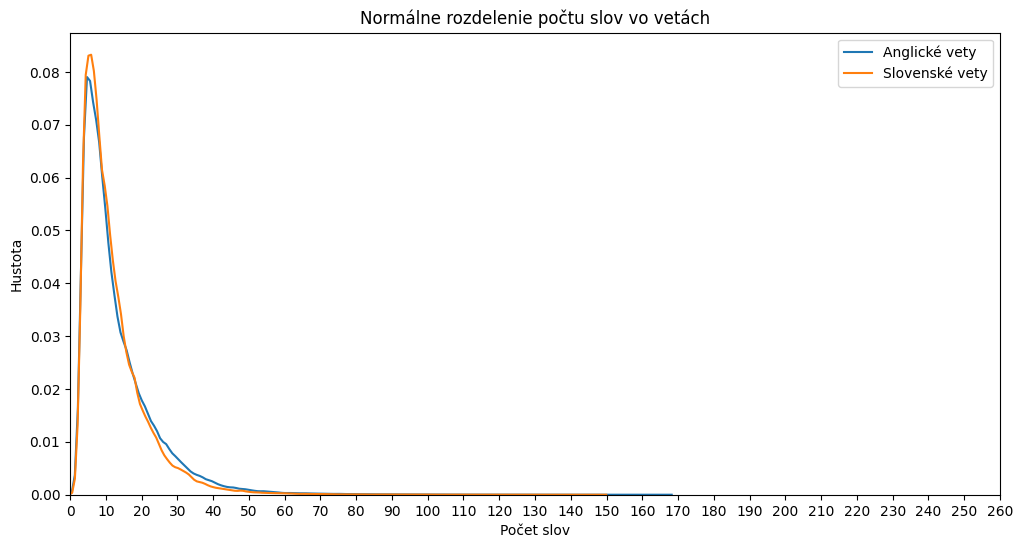

In [7]:
# Graf normálneho rozdelenia počtu slov viet anglického a slovenského textu
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(df['Source_pocet_slov'], ax=ax, label="Anglické vety")
sns.kdeplot(df['Target_pocet_slov'], ax=ax, label="Slovenské vety")

ax.set_xlim(0, 250)
ax.set_xticks(range(0, 261, 10))

ax.set_title("Normálne rozdelenie počtu slov vo vetách")
ax.set_xlabel("Počet slov")
ax.set_ylabel("Hustota")
ax.legend()

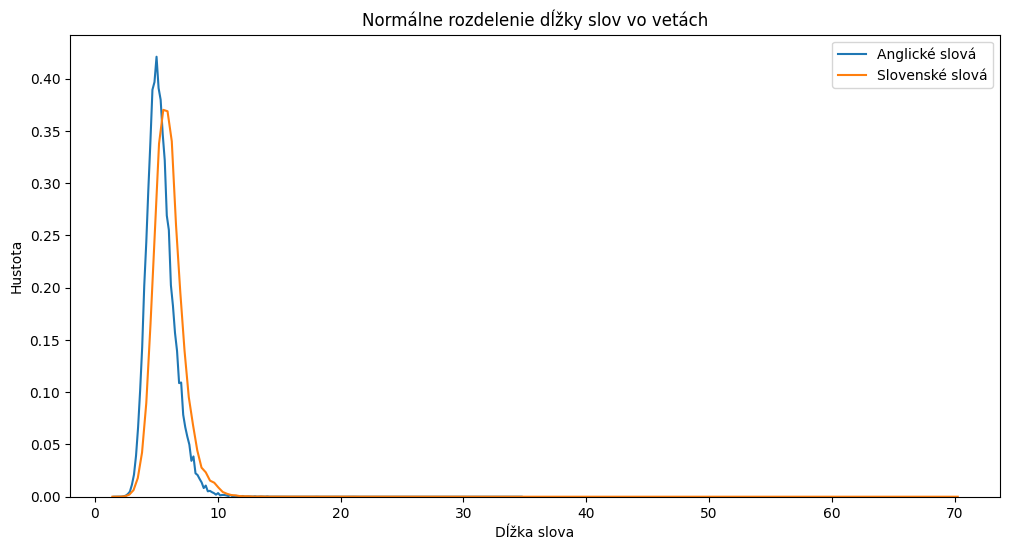

In [8]:
# Graf normálneho rozdelenia dĺžky viet slov  anglického a slovenského textu
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(df['Source_dlzka_slova'], ax=ax, label="Anglické slová")
sns.kdeplot(df['Target_dlzka_slova'], ax=ax, label="Slovenské slová")

ax.set_title("Normálne rozdelenie dĺžky slov vo vetách")
ax.set_xlabel("Dĺžka slova")
ax.set_ylabel("Hustota")
ax.legend()

## Hlavné čistenie a úprava korpusu

In [9]:
start_time = time.time()

df_source = pd.read_csv(en_parl, names=['Source'], sep="\0", quoting=csv.QUOTE_NONE, skip_blank_lines=False) # dataset pre anglický text (source)
df_target = pd.read_csv(sk_parl, names=['Target'], sep="\0", quoting=csv.QUOTE_NONE, skip_blank_lines=False) # dataset pre slovenský text (target)
df = pd.concat([df_source, df_target], axis=1)
print("Rozmery datasetu (riadky, stĺpce):", df.shape)


# Odstránenie NaN hodnôt
pocet_riadkov = df.shape[0]
df = df.dropna()
odstranene_riadky = pocet_riadkov - df.shape[0]
print_status("Riadky bez NaN hodnôt\t\t\t\t\t        ", df.shape[0], odstranene_riadky, time.time() - start_time)


# Zmeny niektorých znakov, na základe zistení pomocou unicode normalizácie NFKC
pocet_riadkov = df.shape[0]

original_source = df['Source'] # budúca referencia ako počet zmenených znakov
original_target = df["Target"] # budúca referencia ako počet zmenených znakov

# Odstránenie exponentov, ktoré nie sú veďla čísel (väčšinou sa jedná o exponenty, ktoré referujú na zdroj, čo nie je žiadúce v našom modely) a zároveň sú dané slová dlhšie ako 3, aby sme omylom nevymazali znak pre miery ako napríklad km, m atď.
df['Source'] = df['Source'].str.replace(r'(\b\w{4,})\s*([¹²³⁴⁵⁶⁷⁸⁹⁰]+)', r'\1', regex=True)
df['Target'] = df['Target'].str.replace(r'(\b\w{4,})\s*([¹²³⁴⁵⁶⁷⁸⁹⁰]+)', r'\1', regex=True)

# Transformácia º (U+00BA) a ˚ (U+02DA) na  ̊ (U+030A) pre zjednotenie znaku stupňa
df['Source'] = df['Source'].str.replace('\u00BA', '\u030A')
df['Target'] = df['Target'].str.replace('\u00BA', '\u030A')
df['Source'] = df['Source'].str.replace('\u02DA', '\u030A')
df['Target'] = df['Target'].str.replace('\u02DA', '\u030A')

# Transformácia ½ (U+00BD) na ,5
df['Source'] = df['Source'].str.replace('\u00BD', ',5')
df['Target'] = df['Target'].str.replace('\u00BD', ',5')

# Porovnanie pôvodných a normalizovaných hodnôt ako reťazcov a spočítanie zmenených riadkov
source_sum = (original_source != df['Source']).sum()
target_sum = (original_target != df['Target']).sum()

prejdeny_cas = time.time() - start_time
print(f"\nNormalizácia na základe UNICODE znakov\t\t\t         Riadky: {df.shape[0]} | Počet zmenených riadkov v source (ANG): {source_sum} | Počet zmenených riadkov v target (SK): {target_sum} | Čas: {prejdeny_cas:.2f} sekúnd")


# Odstránenie riadkov kde sa riadok source rovná riadku target
pocet_riadkov = df.shape[0]
df = df[df['Source'] != df['Target']]
odstranene_riadky = pocet_riadkov - df.shape[0]
print_status("Odstránenie riadkov, kde sa riadok source rovná riadku target\t", df.shape[0], odstranene_riadky, time.time() - start_time)


# Odstránenie duplikátov
pocet_riadkov = df.shape[0]
df = df.drop_duplicates()
odstranene_riadky = pocet_riadkov - df.shape[0]
print_status("Odstránenie duplicitných/rovnakých riadkov\t\t\t", df.shape[0], odstranene_riadky, time.time() - start_time)


# Odstránenie v dôsledku príliš dlhých viet source/target
# Dĺžka, ktorá sa považuje za "príliš dlhú" záleží od jazyka
pocet_riadkov = df.shape[0]
max_sentence_length = 175
df = df[~((df['Source'].str.count(' ') > max_sentence_length) | (df['Target'].str.count(' ') > max_sentence_length))]
odstranene_riadky = pocet_riadkov - df.shape[0]
print_status("Odstránenie príliš dlhých viet source/target\t\t        ", df.shape[0], odstranene_riadky, time.time() - start_time)

# Odstránenie stopwords
#stop_words_en = STOP_WORDS_EN
#stop_words_sk = STOP_WORDS_SK
#df['Source'] = df['Source'].apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words_en]))
#df['Target'] = df['Target'].apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words_sk]))
#odstranene_riadky = 0
#print_status("Odstránenie stopwords\t\t\t\t\t        ", df.shape[0], odstranene_riadky, time.time() - start_time)

# Stemming
#stemmer = PorterStemmer()
#df['Source'] = df['Source'].apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split()]))
#df['Target'] = df['Target'].apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split()]))
#print_status("Stemming\t\t\t\t\t\t\t        ", df.shape[0], odstranene_riadky, time.time() - start_time)

# konverzia špeciálnych znakov
pocet_riadkov = df.shape[0]

df['Source'] = df['Source'].str.replace(r'&amp;', '&', regex=True)
df['Source'] = df['Source'].str.replace(r'&quot;', '"', regex=True)
df['Source'] = df['Source'].str.replace(r'&apos;', '\'', regex=True)
df['Source'] = df['Source'].str.replace(r'&lt;', '<', regex=True)
df['Source'] = df['Source'].str.replace(r'&gt;', '>', regex=True)

df['Target'] = df['Target'].str.replace(r'&amp;', '&', regex=True)
df['Target'] = df['Target'].str.replace(r'&quot;', '"', regex=True)
df['Target'] = df['Target'].str.replace(r'&apos;', '\'', regex=True)
df['Target'] = df['Target'].str.replace(r'&lt;', '<', regex=True)
df['Target'] = df['Target'].str.replace(r'&gt;', '>', regex=True)
print_status("Konverzia špeciálnych znakov\t\t\t        	", df.shape[0], odstranene_riadky, time.time() - start_time)

# Odstránenie znakov, ktoré nie sú písmená/čísla
df['Source'] = df['Source'].str.replace('[^\w\s]', '', regex=True)
df['Target'] = df['Target'].str.replace('[^\w\s]', '', regex=True)
odstranene_riadky = pocet_riadkov - df.shape[0]
print_status("Odstránenie znakov, ktoré nie sú písmená/čísla\t\t\t", df.shape[0], odstranene_riadky, time.time() - start_time)

# konverzia na malé písmená
pocet_riadkov = df.shape[0]
df['Source'] = df['Source'].str.lower()
df['Target'] = df['Target'].str.lower()
prejdeny_cas = time.time() - start_time
odstranene_riadky = pocet_riadkov - df.shape[0] # tu je to len, aby to pasovalo pre funkciu print_status
print_status("Riadky sú konvertované na malé písmená (lowercase)\t\t", df.shape[0], odstranene_riadky, time.time() - start_time)


# Nahradenie prázdnych riadkov NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# Dodatočné odstránenie riadkov, kde je NaN, ktoré mohli vzniknúť v dôsledku minulých krokov
pocet_riadkov = df.shape[0]
df = df.dropna()
odstranene_riadky = pocet_riadkov - df.shape[0]
print_status("Riadky bez NaN hodnôt\t\t\t\t\t        ", df.shape[0], odstranene_riadky, time.time() - start_time)

# kontrola jazyka - tento proces trvá najdlhšie
def safe_detect(text):
    try:
        return detect(text)
    except LangDetectException:
        return None

pocet_riadkov = df.shape[0]
df['source_jazyk'] = df['Source'].apply(lambda x: safe_detect(x) if x and len(x.split()) > 1 else None)
df['target_jazyk'] = df['Target'].apply(lambda x: safe_detect(x) if x and len(x.split()) > 1 else None)

df = df[(df['source_jazyk'] == "en") & (df['target_jazyk'] == "sk")]
df.drop(columns=['source_jazyk', 'target_jazyk'], inplace=True)
odstranene_riadky = pocet_riadkov - df.shape[0]
print_status("Kontrola jazykov\t\t\t\t\t        ", df.shape[0], odstranene_riadky, time.time() - start_time)


# Zmenenie poradia riadkov
df = df.sample(frac=1, random_state=42).reset_index(drop=True) # pridanie random_state, aby sme dostali vždy rovnako zamiešaný dataset
print("Prehodenie poradia riadkov\t\t\t\t\t Riadky:", df.shape[0])

prejdeny_cas = time.time() - start_time
print(f"Celkový prejdený čas: {prejdeny_cas:.2f} sekúnd")

source_subor = en_parl+'-filtered.'+ "en"
target_subor = sk_parl+'-filtered.'+ "sk"

df_source_en = df["Source"]
df_target_sk = df["Target"]

df_source_en.to_csv(source_subor, header=False, index=False, quoting=csv.QUOTE_NONE, sep="\n")
print("Source súbor uložený:", source_subor)
df_target_sk.to_csv(target_subor, header=False, index=False, quoting=csv.QUOTE_NONE, sep="\n")
print("Target súbor uložený:", target_subor)

Rozmery datasetu (riadky, stĺpce): (640715, 2)
Riadky bez NaN hodnôt					         Riadky: 640703 | Odstránené riadky: 12, Čas: 3.61 sekúnd

Normalizácia na základe UNICODE znakov			         Riadky: 640703 | Počet zmenených riadkov v source (ANG): 109 | Počet zmenených riadkov v target (SK): 116 | Čas: 15.58 sekúnd
Odstránenie riadkov, kde sa riadok source rovná riadku target	 Riadky: 640703 | Odstránené riadky: 0, Čas: 15.85 sekúnd
Odstránenie duplicitných/rovnakých riadkov			 Riadky: 640703 | Odstránené riadky: 0, Čas: 16.80 sekúnd
Odstránenie príliš dlhých viet source/target		         Riadky: 640703 | Odstránené riadky: 0, Čas: 19.01 sekúnd
Konverzia špeciálnych znakov			        	 Riadky: 640703 | Odstránené riadky: 0, Čas: 23.52 sekúnd
Odstránenie znakov, ktoré nie sú písmená/čísla			 Riadky: 640703 | Odstránené riadky: 0, Čas: 27.52 sekúnd
Riadky sú konvertované na malé písmená (lowercase)		 Riadky: 640703 | Odstránené riadky: 0, Čas: 28.37 sekúnd
Riadky bez NaN hodnôt					        

<ipython-input-9-d099b0d64cc2>:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['source_jazyk', 'target_jazyk'], inplace=True)


Kontrola jazykov					         Riadky: 512232 | Odstránené riadky: 128471, Čas: 10207.57 sekúnd
Prehodenie poradia riadkov					 Riadky: 512232
Celkový prejdený čas: 10207.77 sekúnd
Source súbor uložený: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/ParaCrawl.en-filtered.en
Target súbor uložený: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/ParaCrawl.sk-filtered.sk


# Subwording

In [7]:
#en_filt = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/europarl.sk-en.en-filtered.en"
#sk_filt = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/europarl.sk-en.sk-filtered.sk"

en_filt = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/ParaCrawl.en-filtered.en"
sk_filt = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/ParaCrawl.sk-filtered.sk"

In [8]:
#https://github.com/google/sentencepiece


#Parametre
vocab_size = 8000
character_coverage = 0.9995

# pre prípad veľkých korpusov -> --train_extremely_large_corpus=false

# Model pre subwordovanie anglického textu (source)
source = f'--input={en_filt} --model_prefix=source --vocab_size={vocab_size} --hard_vocab_limit=false --character_coverage={character_coverage} --split_digits=true --model_type=bpe'
spm.SentencePieceTrainer.train(source)
print("Trénovanie SentencePiece modelu bolo pre source súbor dokončené")


# Model pre subwordovanie slovenského textu (target)
target = f'--input={sk_filt} --model_prefix=target --vocab_size={vocab_size} --hard_vocab_limit=false --character_coverage={character_coverage} --split_digits=true --model_type=bpe'
spm.SentencePieceTrainer.train(target)
print("Trénovanie SentencePiece modelu bolo pre target súbor dokončené")

Trénovanie SentencePiece modelu bolo pre source súbor dokončené
Trénovanie SentencePiece modelu bolo pre target súbor dokončené


In [9]:
source_model = r"/content/source.model"
target_model = r"/content/target.model"
#source_subworded = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/source_subworded"
#target_subworded = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/target_subworded"

source_subworded = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/source_subworded"
target_subworded = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/target_subworded"

In [10]:
def subwordovanie(sp, vstup, vystup, interval=100000):
    try:
        with open(vstup, encoding="utf-8") as vstup, open(vystup, "w+", encoding="utf-8") as vystup:
            for i, line in enumerate(vstup):
                line = line.strip()
                tokens = sp.encode_as_pieces(line)
                vystup.write(" ".join(tokens) + "\n")

                if (i + 1) % interval == 0:
                    print(f"Spracovaných {i + 1} riadkov v {vstup}")
    except Exception as e:
        print(f"Nastala chyba v procese {vstup}: {e}")

sp = spm.SentencePieceProcessor()

sp.load(source_model)
subwordovanie(sp, en_filt, source_subworded)
print(f"Subwordovanie Source súboru bolo dokončené: {source_subworded}")

sp.load(target_model)
subwordovanie(sp, sk_filt, target_subworded)
print(f"Subwordovanie Target súboru bolo dokončené: {target_subworded}")

Spracovaných 100000 riadkov v <_io.TextIOWrapper name='/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/ParaCrawl.en-filtered.en' mode='r' encoding='utf-8'>
Spracovaných 200000 riadkov v <_io.TextIOWrapper name='/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/ParaCrawl.en-filtered.en' mode='r' encoding='utf-8'>
Spracovaných 300000 riadkov v <_io.TextIOWrapper name='/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/ParaCrawl.en-filtered.en' mode='r' encoding='utf-8'>
Spracovaných 400000 riadkov v <_io.TextIOWrapper name='/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/ParaCrawl.en-filtered.en' mode='r' encoding='utf-8'>
Spracovaných 500000 riadkov v <_io.TextIOWrapper name='/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/ParaCrawl.en-filtered.en' mode='r' encoding='utf-8'>
Subwordovanie Source súboru bolo dokončené: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/source_subworded
Spr

## Výpis riadkov súboru

In [11]:
with open(source_subworded, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:
            break

print()

with open(target_subworded, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:
            break

▁for ▁a ▁more ▁detailed ▁technical ▁walk th rough ▁of ▁creating ▁a ▁web h ook ▁see ▁out going ▁web h ook s ▁in ▁microsoft ▁teams
▁holiday ▁houses ▁ski ▁resorts ▁bos nia ▁and ▁her ze g ov ina
▁google ▁analytics ▁uses ▁socalled ▁cookies ▁ie ▁text ▁files ▁that ▁are ▁stored ▁on ▁your ▁computer ▁and ▁that ▁allow ▁an ▁analysis ▁of ▁the ▁use ▁of ▁the ▁website ▁by ▁you
▁ecb ▁opinion ▁on ▁statistical ▁reporting ▁requirements ▁in ▁the ▁field ▁of ▁payment ▁statistics ▁in ▁poland
▁wr ink le ▁fans ▁and ▁fat ▁v es icles ▁p us hing ▁from ▁the ▁bottom ▁are ▁removed ▁from ▁the ▁bottom ▁ey el ids ▁where ▁these ▁cause ▁bul ging ▁and ▁change ▁in ▁the ▁shape ▁of ▁the ▁face
▁no ▁squ eal ing ▁its ▁hard ▁to ▁break ▁tra ction

▁podrob nejšie ▁technické ▁riešenie ▁vytvá rania ▁web ho ok ▁nájdete ▁v ▁článku ▁web ho ok s ▁odos ie lan ej ▁poš ty ▁v ▁tí moch ▁microsoft
▁dovolenkové ▁domy ▁lyžiarske ▁strediská ▁bo sna ▁a ▁her ce gov ina
▁služba ▁google ▁analytics ▁používa ▁tzv ▁cookies ▁tex tové ▁súbory ▁ktoré ▁sú ▁

# Rozdelenie dát na množiny

Dáta rozdelujeme do 3 častí:

    trénovací dataset - používa sa na trénovanie modelu;
    development dataset - používa sa na validáciu modelu počas trénovania, aby sa mohli vylepšiť parametre modelu
    testovací dataset - používa sa na konečné vyhodotenie (evaluáciu) modelu na modelom nevidených dátach

In [12]:
# source_subor = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/source_subworded"
# target_subor = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/target_subworded"


source_subor = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/source_subworded"
target_subor = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/target_subworded"

In [13]:
np.random.seed(42)


# Veľkosť súborov pre dev a test text
data_size = 4000

development = data_size
test = data_size


def train_test_dev(development, test, source_subor, target_subor):
    df_source = pd.read_csv(source_subor, names=['Source'], sep="\0", quoting=csv.QUOTE_NONE, skip_blank_lines=False, encoding="utf-8")
    df_target = pd.read_csv(target_subor, names=['Target'], sep="\0", quoting=csv.QUOTE_NONE, skip_blank_lines=False, encoding="utf-8")
    df = pd.concat([df_source, df_target], axis=1)

    # Odstránenie prázdnych riadkov
    df.dropna(inplace=True)

    # Zamiešanie datasetu
    df = df.sample(frac=1, random_state=42).reset_index(drop=True) # pridanie random_state, aby sme dostali vždy rovnako zamiešaný dataset

    # Rozdelenie datasetu
    df_dev = df[:development]
    df_test = df[development:development + test]
    df_train = df[development + test:]

    def vytvorenie_suboru(df, source_subor, target_subor):
        df['Source'].to_csv(source_subor, index=False, header=False, quoting=csv.QUOTE_NONE, sep=',')
        df['Target'].to_csv(target_subor, index=False, header=False, quoting=csv.QUOTE_NONE, sep=',')


    vytvorenie_suboru(df_train, source_subor + '.train', target_subor + '.train')
    vytvorenie_suboru(df_dev, source_subor + '.dev', target_subor + '.dev')
    vytvorenie_suboru(df_test, source_subor + '.test', target_subor + '.test')


train_test_dev(development, test, source_subor, target_subor)


In [14]:
#source_test = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/source_subworded.test"
#target_test = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/target_subworded.test"

source_test = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/source_subworded.test"
target_test = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/target_subworded.test"

In [15]:
with open(source_test, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:
            break

print()

with open(target_test, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:
            break

▁ch ich inal es ▁current ▁weather ▁conditions
▁does ▁n ed is ▁offer ▁discounts
▁wednesday ▁august ▁ 3 0 ▁ 2 0 1 7 ▁in ▁fair wood ▁the ▁weather ▁forecast ▁would ▁be
▁k im ek on i ▁current ▁weather ▁conditions
▁there ▁are ▁some ▁shops ▁restaurants ▁a ▁super mark et ▁and ▁a ▁boat ▁harbour ▁there
▁home ▁plan ▁your ▁trip ▁how ▁to ▁ar rive ▁by ▁train

▁ch ich ina les ▁aktuálne ▁poveternostné ▁podmienky
▁ponúka ▁spoločnosť ▁nedis ▁zľavy
▁streda ▁ 6 ▁septembra ▁ 2 0 1 7 ▁v ▁spo k ane ▁počasie ▁bude
▁ba mba din ga ▁aktuálne ▁poveternostné ▁podmienky
▁sú ▁tu ▁obcho dy ▁reštaurácie ▁super mar ket ▁a ▁lo dný ▁prístav
▁home ▁nap ro gra mu j ▁si ▁cestu ▁ako ▁price st ovať ▁vla kom


# Vytvorenie konfigurácie a trénovanie modelu

In [19]:
config = '''

seed: 42 # aby sme dosiahli rovnakých výsledkov a pre lepšie porovnávanie medzi modelmi

save_data: vocab  # zložka, kde sa uloží slovná zásoba vygenerovaná pomocou onmt_build_vocab

data:
    corpus:
        # súbory určené na trénovanie
        #path_src: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/source_subworded.train
        #path_tgt: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/target_subworded.train

        path_src: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/source_subworded.train
        path_tgt: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/target_subworded.train
        transforms: [filtertoolong]
        weight: 1
    valid:
        # súbory určené na validáciu
        #path_src: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/source_subworded.dev
        #path_tgt: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/target_subworded.dev

        path_src: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/source_subworded.dev
        path_tgt: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/target_subworded.dev
        transforms: [filtertoolong]

# súbory, v ktorých je uložená slovná zásoba pre source (anglický jazyk) a target (slovenský jazyk) onmt_build_vocab
src_vocab: vocab/source.vocab
tgt_vocab: vocab/target.vocab

# veľkosť slovnej zásoby - hodnoty by mali byť rovnaké ako v sentencepiece
src_vocab_size: 8000
tgt_vocab_size: 8000

src_subword_model: /content/source.model
tgt_subword_model: /content/target.model

# Miesto uloženia súborov
#log_file:   /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/train.log
#save_model: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/complete_model

save_model: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/complete_model

train_steps: 100000 # počet krokov trénovania
valid_steps: 10000  # po n krokoch vykonať validáciu pomocou dev setu
warmup_steps: 8000 # počet by mal byť priamoúmerný počtu krokov trénovania
early_stopping: 4 # ak sa model nezlepší po n validáciach, trénovanie zastaví
save_checkpoint_steps: 5000   # uloženie modelu po n krokoch
keep_checkpoint: 10  # počet posledných n uložených modelov
report_every: 500 # výpis informácií o trénovaní po n-krokoch

decoder_type: transformer
encoder_type: transformer
word_vec_size: 512   # dimenzionálnosť word embeddingu
hidden_size: 512     # dimenzionálnosť skrytých stavov v enkódery a dekódery
layers: 6             # počet vrstiev v enkódery a dekódery   - alternatíva je enc_layers a dec_layers
transformer_ff: 2048  # dimenzionálnosť doprednej vrstvy v transformery
heads: 8              # počet attention head v multi-head-attention

accum_count: 2 # počet n krokov, po ktorých sa aktualizujú parametre
optim: adam
adam_beta1: 0.9
adam_beta2: 0.998
decay_method: noam
learning_rate: 2.0    # miera učenia
max_grad_norm: 1.0    # gradient clipping, pomáha, aby v modely nenastal explodujúci gradient (nemožnosť modelu sa učiť v dôsledku vysokej miery učenia), emôže pomôcť pre lepšiu stabilitu modelu

param_init: 0.0
param_init_glorot: 'true'
position_encoding: 'true'

batch_size: 1024
valid_batch_size: 1024
batch_type: tokens
normalization: tokens
max_generator_batches: 2

dropout: 0.1           # regularizácia, ktorá vytvára šancu (0.1 = 10%) na "vypnutie" nodu vo vrstve behom trénovania, pomáha proti overfittingu
label_smoothing: 0.1

world_size: 1
gpu_ranks: 0

# INFO
log_file: train.log
log_level: INFO

'''

with open("config.yaml", "w+", encoding="utf-8") as config_yaml:
  config_yaml.write(config)

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2ad78e68-7908-2501-57d8-2e092505cd05)


Použíjeme Framework OpenNMT

In [22]:
# Vytvorenie vocabulary
!onmt_build_vocab -config config.yaml -n_sample -1

[2024-03-07 13:24:51,237 INFO] Counter vocab from -1 samples.
[2024-03-07 13:24:51,237 INFO] n_sample=-1: Build vocab on full datasets.
[2024-03-07 13:25:10,947 INFO] * Transform statistics for corpus(100.00%):
			* FilterTooLongStats(filtered=159)

[2024-03-07 13:25:10,970 INFO] Counters src: 8372
[2024-03-07 13:25:10,970 INFO] Counters tgt: 8210


In [23]:
# Trénovanie the NMT model
!onmt_train -config config.yaml -gpu_ranks 0

[2024-03-07 13:25:18,236 INFO] Parsed 2 corpora from -data.
[2024-03-07 13:25:18,236 INFO] Get special vocabs from Transforms: {'src': [], 'tgt': []}.
[2024-03-07 13:25:18,266 INFO] The first 10 tokens of the vocabs are:['<unk>', '<blank>', '<s>', '</s>', '▁the', '▁', '▁and', '▁of', '▁to', '▁in']
[2024-03-07 13:25:18,267 INFO] The decoder start token is: <s>
[2024-03-07 13:25:18,267 INFO] Building model...
[2024-03-07 13:25:18,747 INFO] Switching model to float32 for amp/apex_amp
[2024-03-07 13:25:18,747 INFO] Non quantized layer compute is fp32
[2024-03-07 13:25:19,034 INFO] NMTModel(
  (encoder): TransformerEncoder(
    (embeddings): Embeddings(
      (make_embedding): Sequential(
        (emb_luts): Elementwise(
          (0): Embedding(8000, 512, padding_idx=1)
        )
        (pe): PositionalEncoding()
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiHeadedAttention(
  

# Preklad

In [24]:
config_translate = '''

#model: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/complete_model_step_100000.pt     # sem vložiť najlepší model trénovania
#src: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/source_subworded.test
#output: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/translated

model: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/complete_model_step_100000.pt     # sem vložiť najlepší model trénovania
src: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/source_subworded.test
output: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/translated

log_file: translate.log

seed: 42

beam_size: 4
min_length: 1
length_penalty: avg

batch_size: 32
gpu: 0

coverage_penalty: summary
beta: 0.5

'''

with open("config_translated.yaml", "w+", encoding="utf-8") as config_yaml:
  config_yaml.write(config_translate)

In [25]:
# Preklad
!onmt_translate -config config_translated.yaml

[2024-03-07 19:13:33,383 INFO] Loading checkpoint from /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/complete_model_step_100000.pt
[2024-03-07 19:13:34,295 INFO] Loading data into the model
[2024-03-07 19:14:10,232 INFO] PRED SCORE: -5.2618, PRED PPL: 192.82 NB SENTENCES: 4000
Time w/o python interpreter load/terminate:  36.87502574920654


In [26]:
#translated = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/translated"
translated = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/translated"
with open(translated, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:
            break

print()

▁ch ich ina les ▁aktuálne ▁poveternostné ▁podmienky
▁ponúka ▁zľavy
▁streda ▁ 3 0 ▁august ▁ 2 0 1 7 ▁v ▁fa ir wood ▁počasie ▁bude
▁ki me ko ni ▁aktuálne ▁poveternostné ▁podmienky
▁v ▁hoteli ▁nájdete ▁obcho dy ▁reštaurácie ▁super mar ket ▁a ▁loď
▁home ▁nap lá nu jte ▁si ▁cestu ▁ako ▁sa ▁dostať ▁vla kom



In [27]:
target_model = r"/content/target.model"
#translation = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/translated"
translation = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/translated"
translation_desubword = translation + ".desubword"

sp = spm.SentencePieceProcessor()
sp.load(target_model)

# Desubword prekladový súbor
with open(translation, encoding='utf-8') as vstup, open(translation_desubword, "w", encoding='utf-8') as vystup:
    for line in vstup:
        desub = sp.decode_pieces(line.strip().split(" "))
        vystup.write(desub + "\n")

print(f"Dekódovanie bolo dokončené! Výstupný súbor: {translation_desubword}")

#target_test = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/target_subworded.test"
target_test = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/target_subworded.test"
target_test_desubword = target_test + ".desubword"

with open(target_test, encoding='utf-8') as vstup, open(target_test_desubword, "w", encoding='utf-8') as vystup:
    for line in vstup:
        desub = sp.decode_pieces(line.strip().split(" "))
        vystup.write(desub + "\n")

print(f"Dekódovanie bolo dokončené! Výstupný súbor: {target_test_desubword}")

Dekódovanie bolo dokončené! Výstupný súbor: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/translated.desubword
Dekódovanie bolo dokončené! Výstupný súbor: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/target_subworded.test.desubword


In [28]:
#reference = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/target_subworded.test.desubword"
#preklad = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/translated.desubword"

reference = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/target_subworded.test.desubword"
preklad = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/translated.desubword"

In [29]:
with open(reference, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:
            break

print()

chichinales aktuálne poveternostné podmienky
ponúka spoločnosť nedis zľavy
streda 6 septembra 2017 v spokane počasie bude
bambadinga aktuálne poveternostné podmienky
sú tu obchody reštaurácie supermarket a lodný prístav
home naprogramuj si cestu ako pricestovať vlakom



In [30]:
with open(preklad, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:
            break

print()

chichinales aktuálne poveternostné podmienky
ponúka zľavy
streda 30 august 2017 v fairwood počasie bude
kimekoni aktuálne poveternostné podmienky
v hoteli nájdete obchody reštaurácie supermarket a loď
home naplánujte si cestu ako sa dostať vlakom



In [ ]:
#!pip install spacy

# Evalvácia

In [31]:
#!python -m spacy download en_core_web_sm
!python -m spacy download xx_ent_wiki_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 88.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('xx_ent_wiki_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [32]:
import spacy
import sacrebleu
from nltk.translate import meteor_score as ms
import nltk
nltk.download('wordnet')

nlp = spacy.load("xx_ent_wiki_sm") #https://github.com/explosion/spacy-models/releases/tag/xx_ent_wiki_sm-3.7.0

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
#reference = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/target_subworded.test.desubword"
#preklad = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/translated.desubword"

In [33]:
# referenčné hodnoty
refs = []

with open(reference, encoding='utf-8') as reference:
    for line in reference:
        line = line.strip()
        refs.append(line)

print("Referenčná veta v SK jazyku:", refs[0]) # výpis prvej referenčenj vety, pomocou ktorej budeme porovnávať vety

refs = [refs]  # list listov, teda forma, ktorú si vyžaduje SacreBLEU

# hodnoty, ktoré sme preložili
preds = []

with open(preklad, encoding='utf-8') as prek:
    for line in prek:
        line = line.strip()
        preds.append(line)

print("Preložená veta:\t\t    ", preds[0]) # výpis prvého preloženého riadka

# BLEU skóre - výpočet BLEU na základe porovnania referenčných viet s preloženými vetami
bleu = sacrebleu.corpus_bleu(preds, refs)
print("BLEU:  ", bleu.score)

# tokenizácia je potrebná pre rozdelenie viet do menších častí (tokenov), aby Meteor dokázal porovnávať slová a ich význam
def tokenizacia(text):
    doc = nlp(text)
    return [token.text for token in doc]

meteor_scores = []
for refs_segment, pred in zip(refs, preds):
    ref = refs_segment[0]
    token_ref = tokenizacia(ref) # tokenizácia referenčných viet
    token_pred = tokenizacia(pred) # tokenizáci preložených viet

    # Výpočet METEOR skóre - meteor skóre narozdiel od bleu zohľadnuje sémantiku do istej miery
    score = ms.meteor_score([token_ref], token_pred) # výpočet meteor skóre pre jednu vetu
    meteor_scores.append(score)

average_meteor_score = sum(meteor_scores) / len(meteor_scores) # výpočet priemeru Meteor skóre, pre celú množinu preložených viet
print("METEOR: ", average_meteor_score)

Referenčná veta v SK jazyku: chichinales aktuálne poveternostné podmienky
Preložená veta:		     chichinales aktuálne poveternostné podmienky
BLEU:   33.559299534790284
METEOR:  0.9921875


In [ ]:
token_ref

['po', 'prvé', 'v', 'eú', 'je', 'nedostatok', 'orgánov']

In [ ]:
token_pred

['po', 'prvé', 'v', 'eú', 'sú', 'k', 'dispozícii', 'nedostatočné', 'orgány']

In [ ]:
from google.colab import runtime
runtime.unassign()